<a href="https://www.kaggle.com/code/dllim1/e2e-insurance-ml?scriptVersionId=107571789" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predicting Motor Insurance Claims and Claim Amount

# About the dataset
In this dataset, we can obtain two targets for prediction - A binary value on whether a claim has occured, and a claim amount given that the claim has occured.

# Objectives
For the first half of this notebook, we define a classficiation problem on whether or not a claim has occured. In the second half, we will repeat the steps, but for a regression problem to predict the numerical value of claim amounts.

The regression model is “by construction” an interpolation model.

The reason for splitting this project as two problems instead of just a regression, is to avoid predicting claims at a low amount, of perhaps only $2, which makes no sense, and the exact claim amount threshold to define that a claim occured may be subject to much debate.

Thus, by classifying whether or not a claim occured, we can then make a regression prediction thereafter, conditional on a claim occurring.

Since there is no test set provided, we will perform a simple hold-out validation as a test set.

This notebook will guide us through an end-to-end process of 
1. Cleaning and Splitting Test Data
2. Exploratory Data Analysis
3. Cross Validation
4. Feature Engineering
5. Feature Selection
6. Fitting the Model
7. Hyperparameter Optimisation


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/car-insurance-claim-data/car_insurance_claim.csv


# 1. Cleaning and Splitting Test Data

### 1.1 Understanding the Dimensions
First, we'll look at basic descriptions of the data to understand what we're working with


In [2]:
input_file = '/kaggle/input/car-insurance-claim-data/car_insurance_claim.csv' 
ori_df = pd.read_csv(input_file)
pd.set_option('display.max_columns', None)
ori_df.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


In [3]:
ori_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          10302 non-null  int64  
 1   KIDSDRIV    10302 non-null  int64  
 2   BIRTH       10302 non-null  object 
 3   AGE         10295 non-null  float64
 4   HOMEKIDS    10302 non-null  int64  
 5   YOJ         9754 non-null   float64
 6   INCOME      9732 non-null   object 
 7   PARENT1     10302 non-null  object 
 8   HOME_VAL    9727 non-null   object 
 9   MSTATUS     10302 non-null  object 
 10  GENDER      10302 non-null  object 
 11  EDUCATION   10302 non-null  object 
 12  OCCUPATION  9637 non-null   object 
 13  TRAVTIME    10302 non-null  int64  
 14  CAR_USE     10302 non-null  object 
 15  BLUEBOOK    10302 non-null  object 
 16  TIF         10302 non-null  int64  
 17  CAR_TYPE    10302 non-null  object 
 18  RED_CAR     10302 non-null  object 
 19  OLDCLAIM    10302 non-nul

In [4]:
print(f"Dataset has {ori_df.shape[0]} rows and {ori_df.shape[1]} columns")
print(f"Duplicates: {ori_df.duplicated().sum()}")
print(f"Total Missing Values: {ori_df.isna().sum().sum()}")
print(f"Number of rows with missing values: {ori_df.isna().any(axis=1).sum()}")

Dataset has 10302 rows and 27 columns
Duplicates: 1
Total Missing Values: 3004
Number of rows with missing values: 2645


Here's what these columns mean, and what effect they may hypothetically have on our target variables. This is just wild conjecture at this point, based on our logical understanding of insurance. Soon, we shall uncover the actual effects!

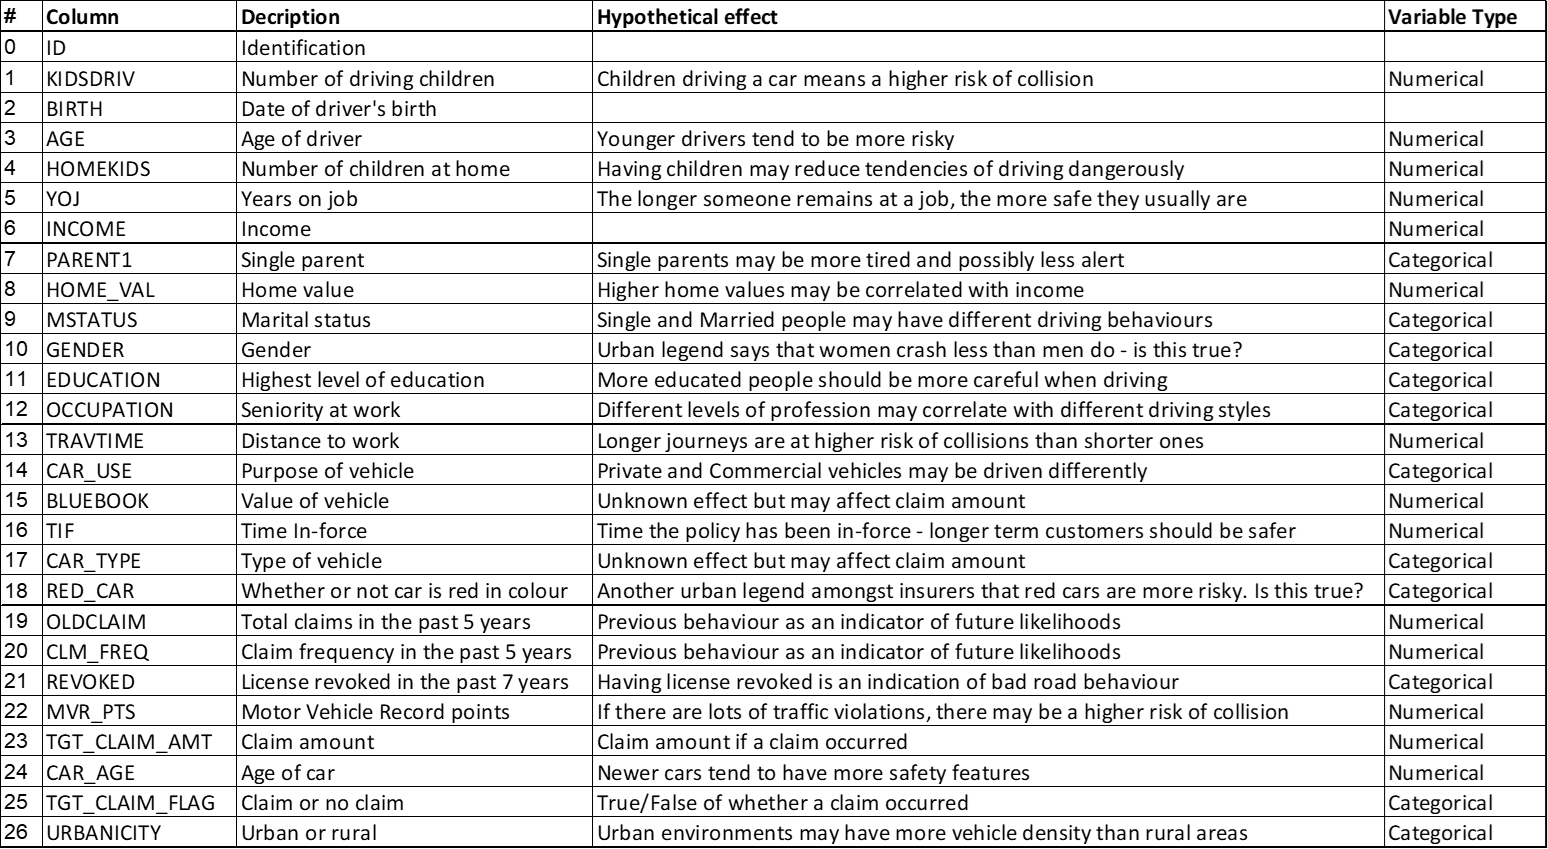

### 1.2 Performing Clean Up of Data
We have to be careful not to fundamentally change any values relative to others while keeping in mind that we should avoid any leakage as we have not yet split our test set.


These cleanups would have been performed at the source level in a production setting, but our line of work isn't perfect, so here we are!

In [5]:
# Create a Population DataFrame copy of the original
pop_df = ori_df.copy()

# Remove the duplicate we saw previously
pop_df.drop_duplicates(inplace=True) # leave this

# Convert currecy into floats
def convert_currency(df, columns: list):
    for col in columns:
        df[col] = np.where(pd.isnull(df[col]), df[col], df[col].astype('str').map(lambda x: x.replace(',','').replace('$',''))).astype('float')

# There are some values that have a prefix 'z_' that does not mean anything. Let my OCD have this one, please.
def remove_z(df, columns: list):
    for col in columns:
        df[col] = np.where(pd.isnull(df[col]), df[col], df[col].astype('str').map(lambda x: x.replace('z_','')))

currency_cols = ['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM','CLM_AMT']
z_cols = ['MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION', 'CAR_TYPE','URBANICITY']

convert_currency(pop_df, currency_cols)
remove_z(pop_df, z_cols)

# Rename our target columns with a prefix 'TGT_' so we can visually identify better.
pop_df.rename({'CLM_AMT': 'TGT_CLAIM_AMT', 'CLAIM_FLAG': 'TGT_CLAIM_FLAG'}, axis=1, inplace=True);

# These columns don't add any value. 'BIRTH' is redundant with the 'AGE' column present
pop_df.drop(['BIRTH','ID'], axis=1, inplace=True);

In [6]:
pop_df.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,TGT_CLAIM_AMT,CAR_AGE,TGT_CLAIM_FLAG,URBANICITY
0,0,60.0,0,11.0,67349.0,No,0.0,No,M,PhD,Professional,14,Private,14230.0,11,Minivan,yes,4461.0,2,No,3,0.0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449.0,No,257252.0,No,M,High School,Blue Collar,22,Commercial,14940.0,1,Minivan,yes,0.0,0,No,0,0.0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881.0,No,0.0,No,M,Bachelors,Manager,26,Private,21970.0,1,Van,yes,0.0,0,No,2,0.0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039.0,No,124191.0,Yes,F,High School,Clerical,5,Private,4010.0,4,SUV,no,38690.0,2,No,3,0.0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,NaN,No,306251.0,Yes,M,<High School,Blue Collar,32,Private,15440.0,7,Minivan,yes,0.0,0,No,0,0.0,6.0,0,Highly Urban/ Urban


In [7]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10301 entries, 0 to 10301
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   KIDSDRIV        10301 non-null  int64  
 1   AGE             10294 non-null  float64
 2   HOMEKIDS        10301 non-null  int64  
 3   YOJ             9753 non-null   float64
 4   INCOME          9731 non-null   float64
 5   PARENT1         10301 non-null  object 
 6   HOME_VAL        9726 non-null   float64
 7   MSTATUS         10301 non-null  object 
 8   GENDER          10301 non-null  object 
 9   EDUCATION       10301 non-null  object 
 10  OCCUPATION      9636 non-null   object 
 11  TRAVTIME        10301 non-null  int64  
 12  CAR_USE         10301 non-null  object 
 13  BLUEBOOK        10301 non-null  float64
 14  TIF             10301 non-null  int64  
 15  CAR_TYPE        10301 non-null  object 
 16  RED_CAR         10301 non-null  object 
 17  OLDCLAIM        10301 non-null 

In [8]:
pop_df.nunique()

KIDSDRIV             5
AGE                 61
HOMEKIDS             6
YOJ                 21
INCOME            8151
PARENT1              2
HOME_VAL          6334
MSTATUS              2
GENDER               2
EDUCATION            5
OCCUPATION           8
TRAVTIME           100
CAR_USE              2
BLUEBOOK          2985
TIF                 23
CAR_TYPE             6
RED_CAR              2
OLDCLAIM          3545
CLM_FREQ             6
REVOKED              2
MVR_PTS             14
TGT_CLAIM_AMT     2346
CAR_AGE             30
TGT_CLAIM_FLAG       2
URBANICITY           2
dtype: int64

In [9]:
print(f"Dataset has {ori_df.shape[0]} rows and {ori_df.shape[1]} columns")
print(f"Duplicates: {ori_df.duplicated().sum()}")
print(f"Total Missing Values: {ori_df.isna().sum().sum()}")
print(f"Number of rows with missing values: {ori_df.isna().any(axis=1).sum()}")

Dataset has 10302 rows and 27 columns
Duplicates: 1
Total Missing Values: 3004
Number of rows with missing values: 2645


In [10]:
# Let's define the categorical columns and numerical columns which will be later used as features
categorical_cols = [col for col in pop_df.columns if (pop_df[col].nunique() < 10) and 
                    (pop_df[col].dtype == "object") and
                    col not in ['TGT_CLAIM_AMT','TGT_CLAIM_FLAG']]

numerical_cols = [col for col in pop_df.columns if (pop_df[col].dtype in ['int64', 'float64']) and
                  col not in ['TGT_CLAIM_AMT','TGT_CLAIM_FLAG']]

print('Number of Numerical columns   :',len(numerical_cols))
print('Number of Categorical columns :',len(categorical_cols))

Number of Numerical columns   : 13
Number of Categorical columns : 10


#### Sense check of Targets
"Domain knowledge" time!  
> There shouldn't be any claim amount if there isn't any claim.

In [11]:
# Check for positive claims with non-zero claim amount (there shouldn't be any)
pop_df.loc[(pop_df['TGT_CLAIM_FLAG'] == False) & (pop_df['TGT_CLAIM_AMT'] > 0), ['TGT_CLAIM_FLAG','TGT_CLAIM_AMT']]

,TGT_CLAIM_FLAG,TGT_CLAIM_AMT


In [12]:
# Check for positive claims with zero claim amount (there shouldn't be any here either)
pop_df.loc[(pop_df['TGT_CLAIM_FLAG'] == True) & (pop_df['TGT_CLAIM_AMT'] <= 0), ['TGT_CLAIM_FLAG','TGT_CLAIM_AMT']]

,TGT_CLAIM_FLAG,TGT_CLAIM_AMT


Okay, now we have a base DataFrame where we can begin our work with. I'm going to have a quick chat with the Data Engineer about cleaning this up for next time! Be right back.

### 1.3 Splitting the Test Data

We will artificially select a sample for a hold-out test set, which should have proportionally the amount of positive claims, so that there is enough test data for the claim amount problem in the second half.

One may argue that this is "cheating" by using stratified methods to perform a train-test split, but given what we have, I'm making the judgment call to perform this split this way to minimise sampling errors later on. Given our dataset, which we'll find out later on, there may be many outliers which have to be retained, hence the stratified strategy.

Since this will be (semi)randomly selected once and for all, the distribution of the test set completely is out of control and out of reach of the models. This would also prevent any leakage further down the line.

###### Stratified Hold Out
We've established that we want to perform a stratified split, as a hold out for the test set.

We can stratify on the 0's and 1's of `TGT_CLAIM_FLAG`, but it could produce greater sampling errors for `TGT_CLAIM_AMT`.

So, the best strategy here is to stratify on the `TGT_CLAIM_AMT`

To perform stratification on numerical targets/regression problems, manual folding may be required.

We should split the numerical values in into bins for stratification. But how many bins?

We'll use Sturges' Formula to find the optimal number of bins:
https://en.wikipedia.org/wiki/Histogram#Sturges'_formula

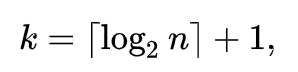

In [13]:
def make_stratified_k_folds(df,tgt_col:str,n_splits):
    # Randomise and reset index for splitting
    df = df.sample(frac=1,random_state=0).reset_index(drop=True)
    n_rows = df.shape[0]
    
    # Calculate k in Sturges Formula
    n_bins = int(np.floor(np.log2(n_rows) + 1))
    
    # Create bins
    df.loc[:,'bins'] = pd.cut(
        df[tgt_col], bins=n_bins, labels=False
    )
    
    skf = StratifiedKFold(n_splits=n_splits)
    for f, (t_, v_) in enumerate(skf.split(X=df, y=df['bins'].values)):
        df.loc[v_, 'kfold'] = f
        
    df = df.drop('bins',axis=1)
    return df

# Create hold-out test fold 
pre_df = make_stratified_k_folds(pop_df,'TGT_CLAIM_AMT',8)
train_df = pre_df.copy().loc[pre_df['kfold'] != 0].drop('kfold', axis=1)
test_df = pre_df.copy().loc[pre_df['kfold'] == 0].drop('kfold', axis=1)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  UserWarning,


In [14]:
# Sense check to see if distribution of TGT_CLAIM_FLAG is almost proportional, since we stratified on TGT_CLAIM_AMT
test_ratio = test_df['TGT_CLAIM_FLAG'].value_counts()[0] / test_df['TGT_CLAIM_FLAG'].value_counts()[1]
ori_ratio = pre_df['TGT_CLAIM_FLAG'].value_counts()[0] / pre_df['TGT_CLAIM_FLAG'].value_counts()[1]
print("{:.4%}".format(test_ratio / ori_ratio - 1), 'difference')

3.3985% difference


Good! That's a negligible difference, so our split is proportional. From here on, we won't touch the test data. All exploration and model training will be done on the training set.

# 2. Exploratory Data Analysis
### 2.1 Exploring Feature Distribution

Here, we will look at the distribution of each column and observe anomalies, if any.

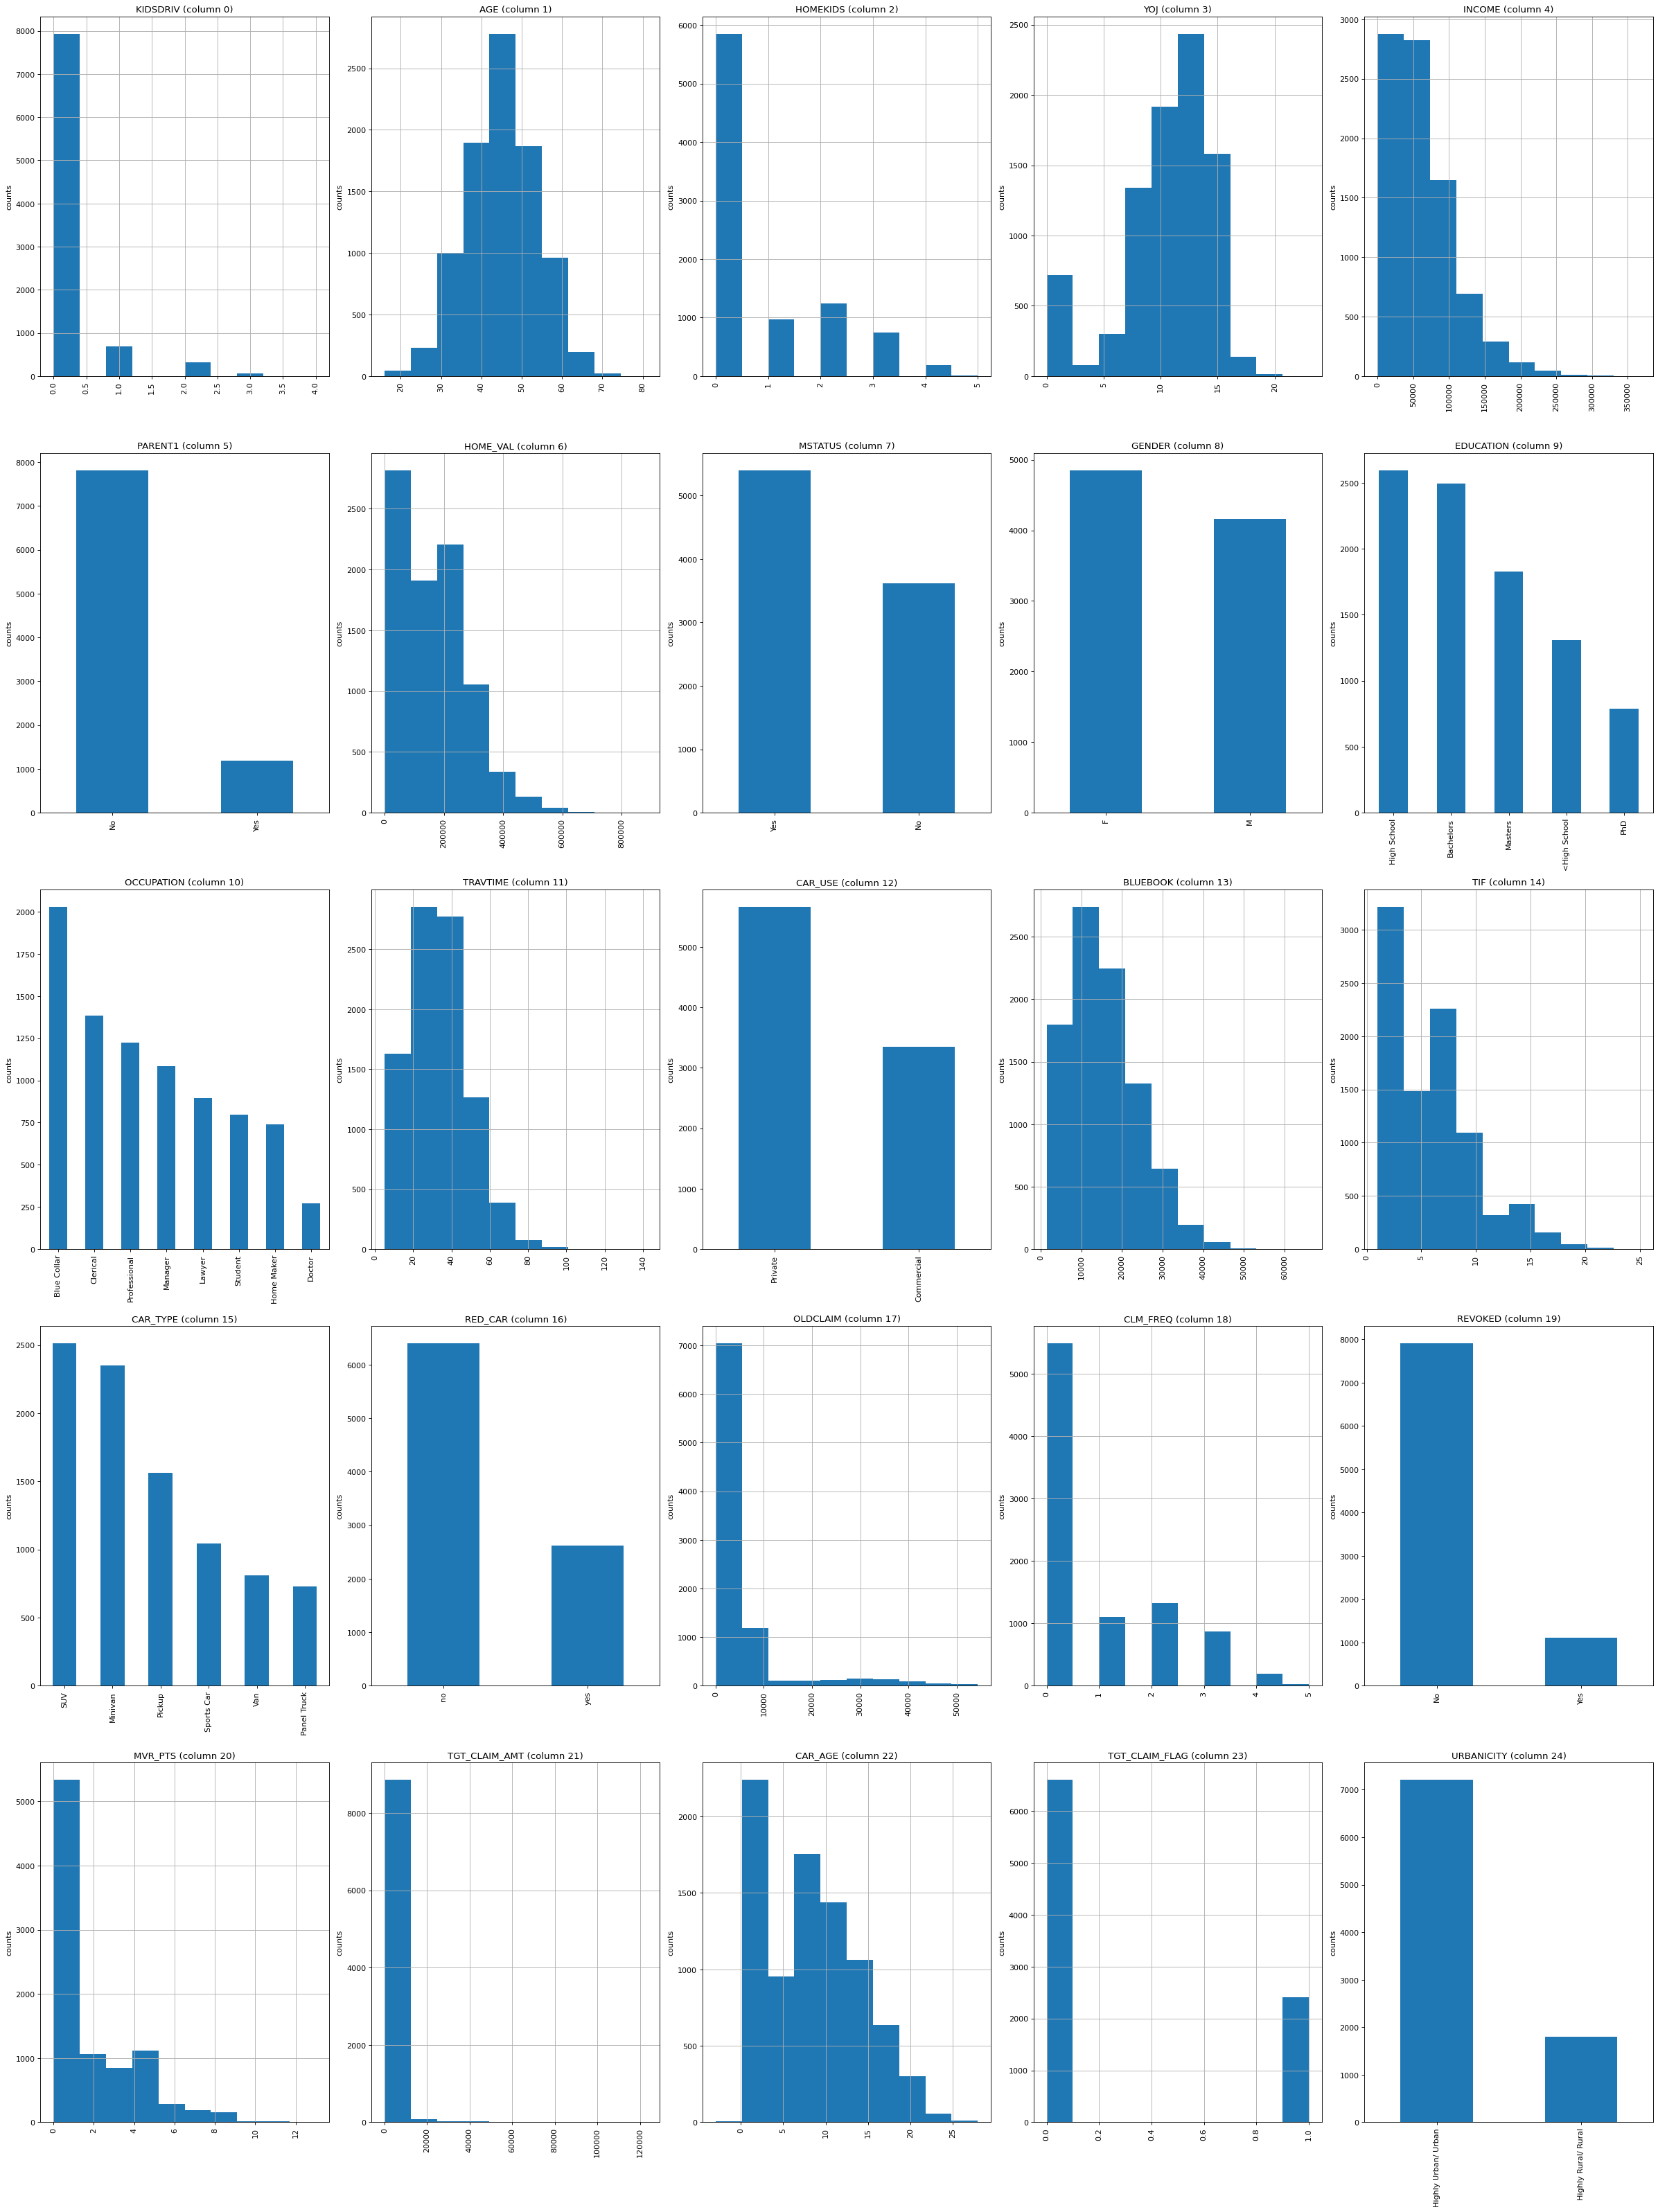

In [15]:
def plot_col_distribution(df, n_graph_per_row):
    n_col = df.shape[1]
    column_names = list(df)
    n_graph_row = (n_col + n_graph_per_row - 1) // n_graph_per_row
    plt.figure(num = None, figsize = (6 * n_graph_per_row, 8 * n_graph_row), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(n_col):
        plt.subplot(n_graph_row, n_graph_per_row, i + 1)
        column_df = df.iloc[:, i]
        if (not np.issubdtype(type(column_df.iloc[0]), np.number)):
            column_df.value_counts().plot.bar()
        else:
            column_df.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{column_names[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    
plot_col_distribution(train_df,5)

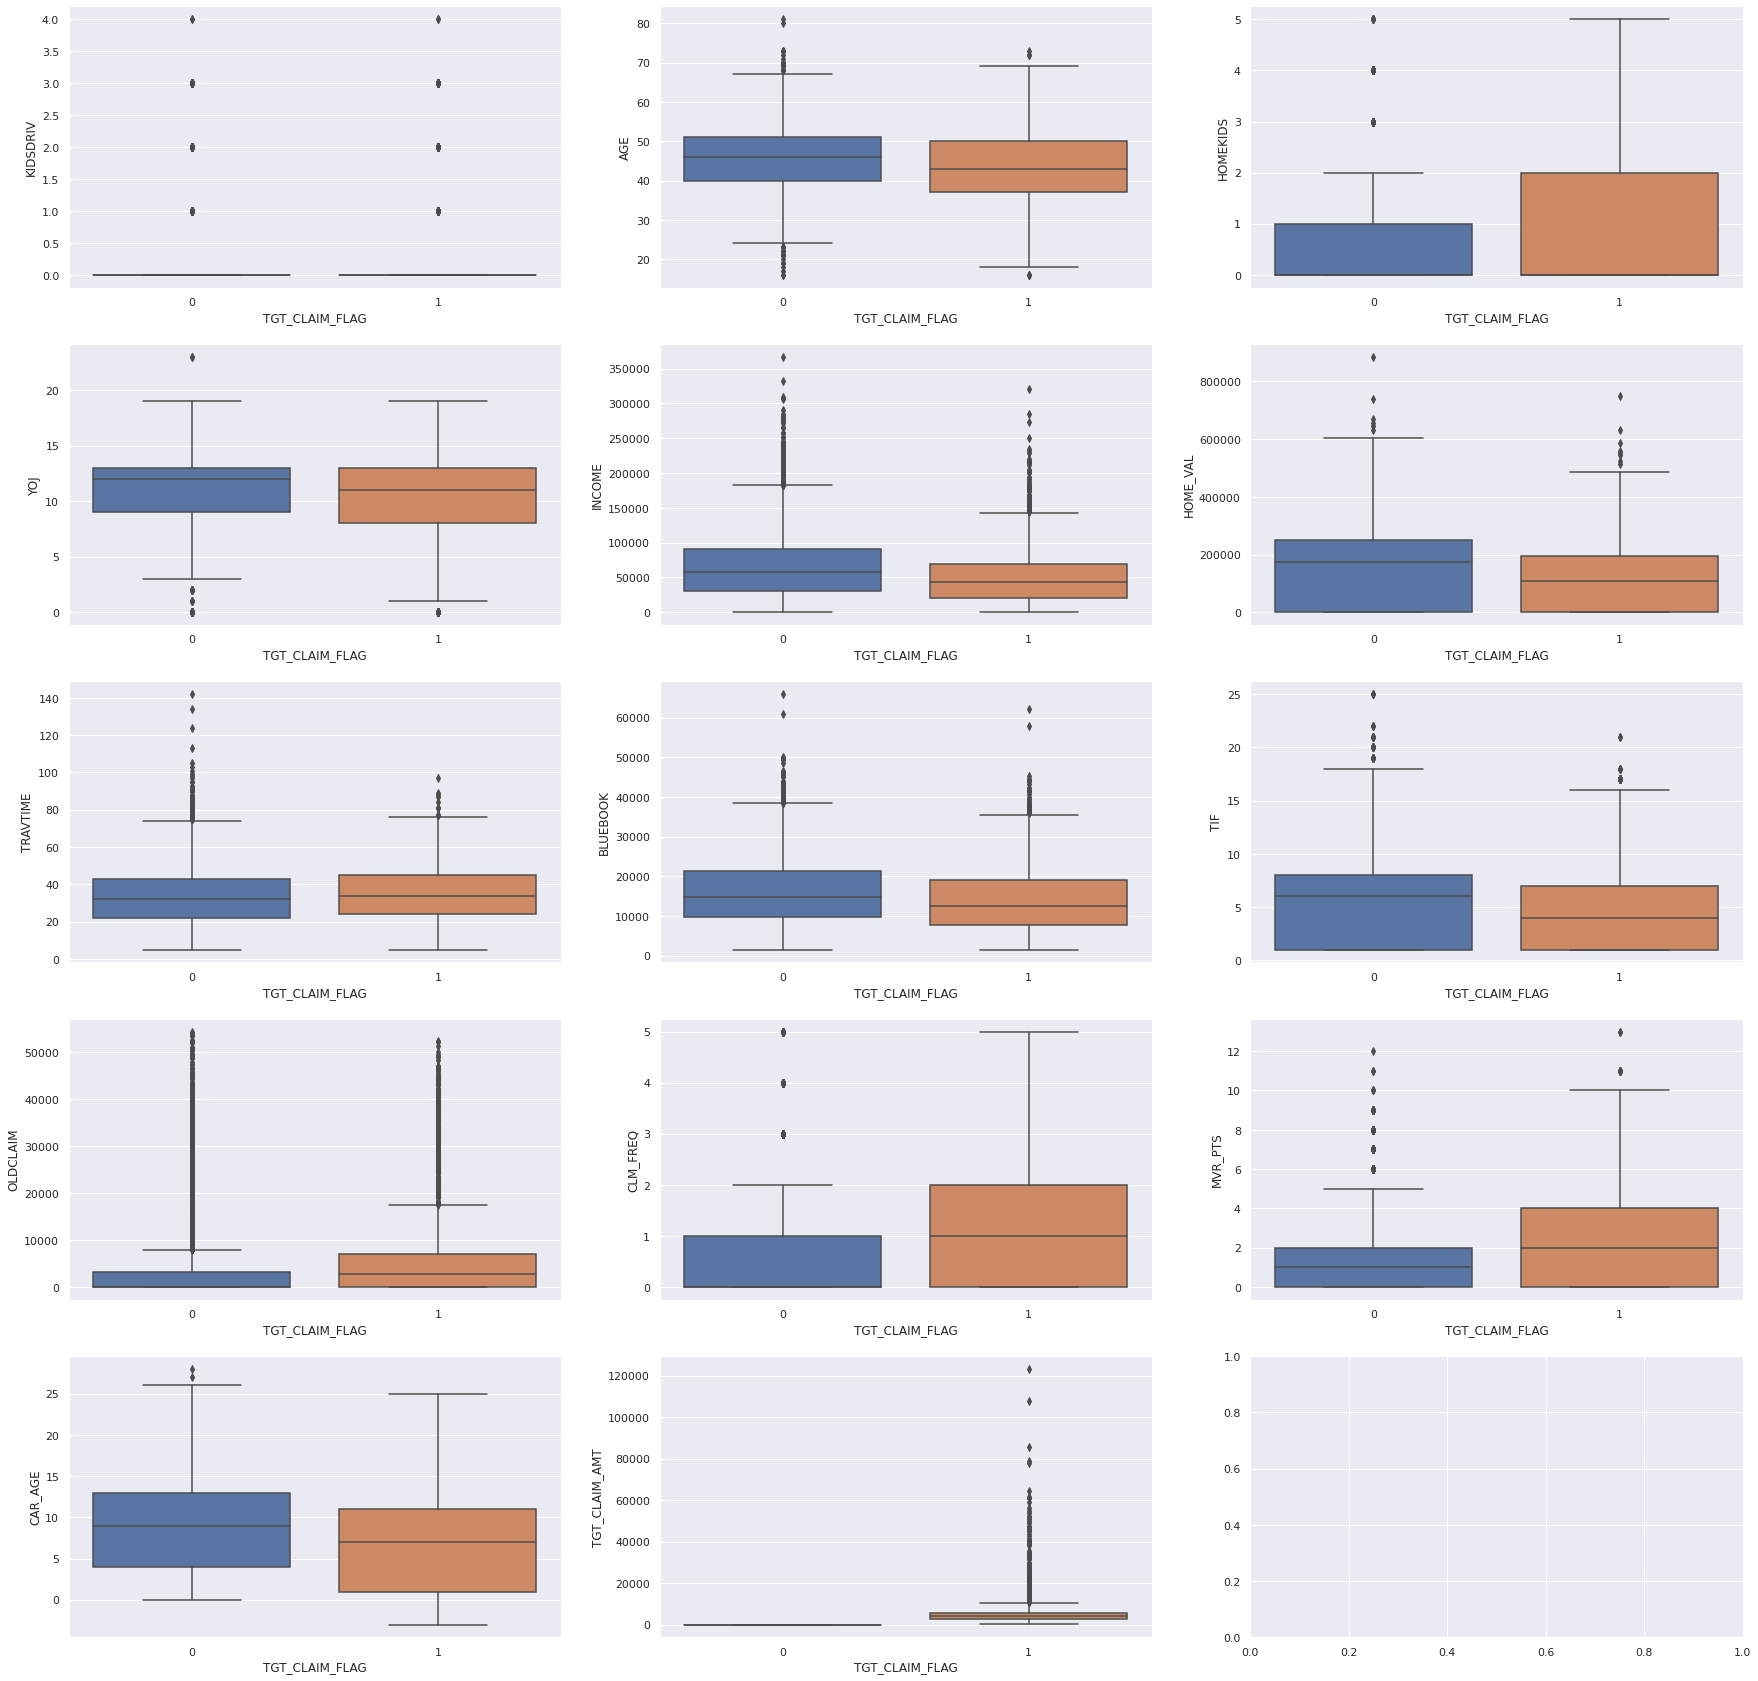

In [16]:
def plot_boxplot_by_claim_flag(df,cols,n_graph_per_row):
    sns.set_theme()
    n_rows, n_cols = 5,3
    figure, axis = plt.subplots(n_rows, n_cols, figsize = (30,30))
    i = 0
    for col in cols:
        j = i//n_cols
        k = i%n_cols
        sns.boxplot(y=col, x='TGT_CLAIM_FLAG', data=df, ax=axis[j,k])
        i +=1
        
all_num_cols = numerical_cols + ['TGT_CLAIM_AMT']
plot_boxplot_by_claim_flag(train_df,all_num_cols,5)

REMARKS tgt claim amt

### 2.2 Checking Correlation between Variables
Understanding how the variables are related can tell us more about whether or not features are redundant. Redundant features can negatively impact the performance of the model.

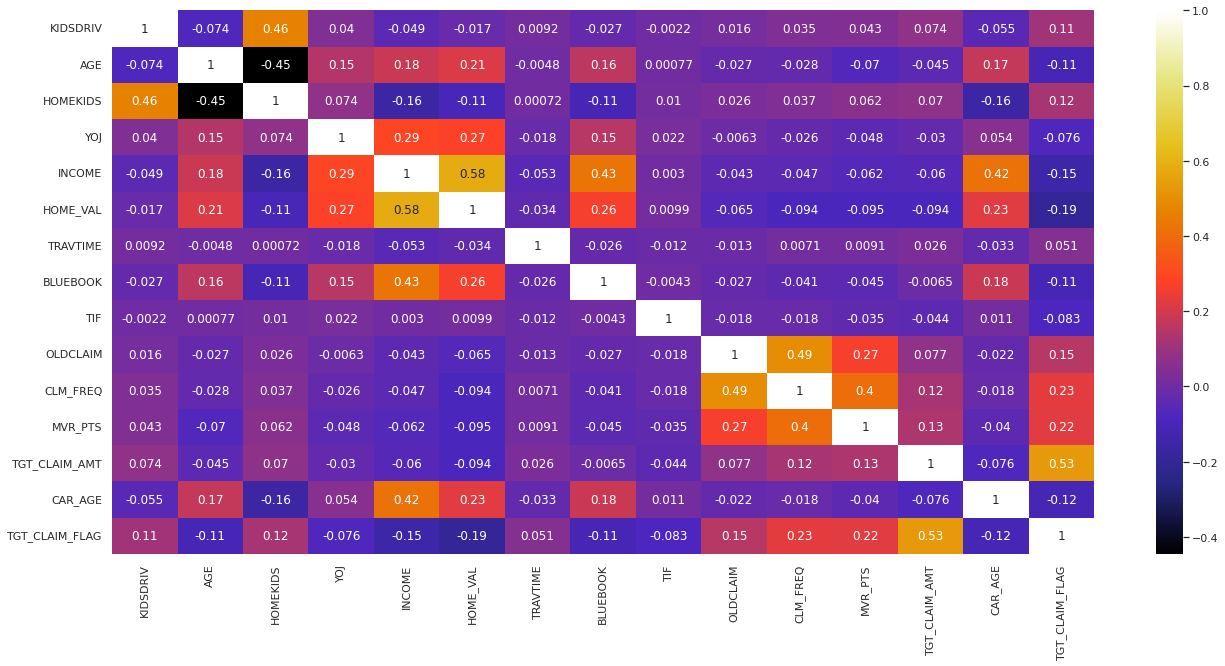

In [17]:
def plot_corr(df):
    corr = df.corr()
    sns.set_theme()
    plt.figure(figsize = (22,10))
    sns.heatmap(corr, cbar=True, annot=True, cmap='CMRmap')
plot_corr(train_df)

At a glance, most features are not generally correlated, which would be good for use in the model later.

For `'HOMEKIDS','KIDSDRIV','AGE'`, there is some correlation with each other. It makes sense that more kids at home increases the likelihood of a kid driving. Age is negatively correlated, which may suggest that only younger adults have children, and children leave their parents house relatively younger generally. See graph below:

<AxesSubplot:xlabel='AGE', ylabel='HOMEKIDS'>

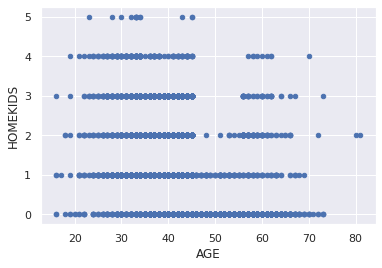

In [18]:
train_df.plot.scatter('AGE','HOMEKIDS')

There's also another hotspot with `'INCOME','HOME_VAL','BLUEBOOK','YOJ','CAR_AGE'`. High income earners tend to buy higher valued homes, and more expensive cars. They also tend to have worked more years on the job. 

Somehow, they also have older cars - a taste for classics? Or too frugal to get a new one? "Just gets me from point A to point B!"

In [19]:
# show some graph here?
    
income_df = train_df[['INCOME','HOME_VAL','BLUEBOOK','YOJ','CAR_AGE']]


Another cluster is `'OLDCLAIM','CLM_FREQ','MVR_PTS'`, where drivers with higher Motor Vehicle Record points tend to have more collisions and thus a history of claims. But does this necessarily mean they will do it again?

### 2.3 Number of Categories in Each Categorical Feature
Too many categories make a feature less viable as a categorical feature.

In [20]:
for col in categorical_cols:
    print(col, 'has', pop_df[col].nunique(),'unique variables')
    

PARENT1 has 2 unique variables
MSTATUS has 2 unique variables
GENDER has 2 unique variables
EDUCATION has 5 unique variables
OCCUPATION has 8 unique variables
CAR_USE has 2 unique variables
CAR_TYPE has 6 unique variables
RED_CAR has 2 unique variables
REVOKED has 2 unique variables
URBANICITY has 2 unique variables


Fortunately, all categorical featuers have a healthy number of categories

### 2.4 Check for Missing Values



In [21]:
print(f"Missing Values in DF: {train_df.isna().sum().sum()}")
print("\n")

def find_missing(df, cols:list):
    for i in cols:
        print(" - ", i, f", Missing: {df[i].isna().sum()}")
    print("\n")

print("Categorical features are:")
find_missing(train_df, categorical_cols)
print("Numerical features are:")
find_missing(train_df, numerical_cols)

print("Targets")
find_missing(train_df, ['TGT_CLAIM_FLAG','TGT_CLAIM_AMT'])

Missing Values in DF: 2623


Categorical features are:
 -  PARENT1 , Missing: 0
 -  MSTATUS , Missing: 0
 -  GENDER , Missing: 0
 -  EDUCATION , Missing: 0
 -  OCCUPATION , Missing: 582
 -  CAR_USE , Missing: 0
 -  CAR_TYPE , Missing: 0
 -  RED_CAR , Missing: 0
 -  REVOKED , Missing: 0
 -  URBANICITY , Missing: 0


Numerical features are:
 -  KIDSDRIV , Missing: 0
 -  AGE , Missing: 6
 -  HOMEKIDS , Missing: 0
 -  YOJ , Missing: 474
 -  INCOME , Missing: 501
 -  HOME_VAL , Missing: 510
 -  TRAVTIME , Missing: 0
 -  BLUEBOOK , Missing: 0
 -  TIF , Missing: 0
 -  OLDCLAIM , Missing: 0
 -  CLM_FREQ , Missing: 0
 -  MVR_PTS , Missing: 0
 -  CAR_AGE , Missing: 550


Targets
 -  TGT_CLAIM_FLAG , Missing: 0
 -  TGT_CLAIM_AMT , Missing: 0




### 2.5 Selecting Model and Metrics
###### For the classification problem with `TGT_CLAIM_FLAG`:

This is a binary classification problem. We'll explore all True and False Positives/Negatives combinations with the Confusion Matrix and the F1-score, derived of as a "harmonic mean" of Precision and Recall ;)

We'll also primarily use Area Under ROC Curve (AUC) as a metric on how well generalised the model is.

For this experiment, we'll use the most popular Tree-based algorithm, XGBoost

###### For the regression problem with `TGT_CLAIM_AMT`:

> rmse


# 3. Cross Validation
Here, we will begin splitting our data to perform cross-validation when training the models.

We'll use a Stratified K-fold approach once again.

For simplicity's sake, instead of stratifying on `TGT_CLAIM_FLAG` and then on `TGT_CLAIM_AMT` again, we'll assume the latter is sufficient for our purposes here.

We'll reuse the code from previously.

In [22]:
n_folds = 5
train_cv_df = make_stratified_k_folds(train_df,'TGT_CLAIM_AMT',n_folds)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [23]:
train_cv_df.shape

(9013, 26)

In [24]:
train_cv_df.columns

Index(['KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL',
       'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION', 'TRAVTIME', 'CAR_USE',
       'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM', 'CLM_FREQ',
       'REVOKED', 'MVR_PTS', 'TGT_CLAIM_AMT', 'CAR_AGE', 'TGT_CLAIM_FLAG',
       'URBANICITY', 'kfold'],
      dtype='object')

# 4. Feature Engineering

Looking at the first problem, which is our Binary Classification problem of whether or not a claim is made, we've decided to use a tree-based algorithm which can handle categorical variables with ease. Nevertheless, we'll still need to deal with missing values


### 4.1 Imputing Missing Values in Numerical Variables

We can always do better than naive approaches, so for features with missing values, we'll use a KNN imputation where possible, since it "interpolates" data based on what's available

KNN imputation does not work on categorical values, so we'll apply KNN on numerical features only.




In [25]:
# Define imputers we'll be using
knn_imputer = KNNImputer(n_neighbors=2)

# Function to show a sample of the missing values that will be imputed
def show_missing_head(df,cols,n=5):
    df = df[cols]
    missing = df[df.isna().any(axis=1)].head(n)
    print('These are some samples with missing values')
    display(missing)
    print('\n')
    return missing.index.to_list()

# Some boiler plate code to impute and then sense check imputed values
def imputer_with_tester(input_df, cols, imputer, test_samples):

    df = input_df[cols]
    df_imputed = pd.DataFrame(imputer.fit_transform(df))
    df_imputed.columns = df.columns
    print('The same samples with missing values imputed')
    display(df_imputed.loc[test_samples])
    
    imputed_missing_df = df_imputed[df_imputed.isna().any(axis=1)]
    print('Sense check for any empty values remaining')
    display(imputed_missing_df)
    print('The imputed df is empty:',imputed_missing_df.empty)
    print('\n')
    return df_imputed

# Find missing values and impute numerical columns
print('NUMERICAL FEATURES')
missing_num_samples = show_missing_head(train_cv_df, numerical_cols)
train_cv_df_num_imp = imputer_with_tester(train_cv_df, numerical_cols, knn_imputer, missing_num_samples)

NUMERICAL FEATURES
These are some samples with missing values


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE
0,0,30.0,1,12.0,NaN,0.0,40,19340.0,4,1474.0,3,4,19.0
3,0,45.0,3,14.0,61952.0,252391.0,20,31010.0,6,0.0,0,1,NaN
6,0,39.0,1,6.0,56014.0,234014.0,28,23370.0,1,0.0,0,0,NaN
10,0,58.0,0,NaN,229207.0,588059.0,46,30220.0,6,11827.0,1,4,3.0
12,1,39.0,2,NaN,5645.0,0.0,13,5400.0,6,5055.0,3,0,1.0




The same samples with missing values imputed


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE
0,0.0,30.0,1.0,12.0,47767.0,0.0,40.0,19340.0,4.0,1474.0,3.0,4.0,19.0
3,0.0,45.0,3.0,14.0,61952.0,252391.0,20.0,31010.0,6.0,0.0,0.0,1.0,10.0
6,0.0,39.0,1.0,6.0,56014.0,234014.0,28.0,23370.0,1.0,0.0,0.0,0.0,6.0
10,0.0,58.0,0.0,9.5,229207.0,588059.0,46.0,30220.0,6.0,11827.0,1.0,4.0,3.0
12,1.0,39.0,2.0,7.0,5645.0,0.0,13.0,5400.0,6.0,5055.0,3.0,0.0,1.0


Sense check for any empty values remaining


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE


The imputed df is empty: True




### 4.2 Imputing Missing Values in Categorical Variables
With missing categorical values, we'll park them to a new category called "MISSING" and reuse the code from before

In [26]:
# Define imputers we'll be using
cat_imputer = SimpleImputer(strategy='constant', fill_value='MISSING')

# Repeat for categorical columns, with the Simple 
print('CATEGORICAL FEATURES')
missing_cat_samples = show_missing_head(train_cv_df, categorical_cols)
train_cv_df_cat_imp = imputer_with_tester(train_cv_df, categorical_cols, cat_imputer, missing_cat_samples)

CATEGORICAL FEATURES
These are some samples with missing values


,PARENT1,MSTATUS,GENDER,EDUCATION,OCCUPATION,CAR_USE,CAR_TYPE,RED_CAR,REVOKED,URBANICITY
31,No,Yes,M,Masters,NaN,Commercial,Panel Truck,yes,No,Highly Urban/ Urban
47,No,Yes,F,Masters,NaN,Private,SUV,no,No,Highly Urban/ Urban
52,No,No,M,Masters,NaN,Commercial,Panel Truck,yes,Yes,Highly Urban/ Urban
55,No,No,M,PhD,NaN,Commercial,Panel Truck,no,No,Highly Urban/ Urban
71,No,Yes,M,Masters,NaN,Commercial,Van,no,No,Highly Urban/ Urban




The same samples with missing values imputed


,PARENT1,MSTATUS,GENDER,EDUCATION,OCCUPATION,CAR_USE,CAR_TYPE,RED_CAR,REVOKED,URBANICITY
31,No,Yes,M,Masters,MISSING,Commercial,Panel Truck,yes,No,Highly Urban/ Urban
47,No,Yes,F,Masters,MISSING,Private,SUV,no,No,Highly Urban/ Urban
52,No,No,M,Masters,MISSING,Commercial,Panel Truck,yes,Yes,Highly Urban/ Urban
55,No,No,M,PhD,MISSING,Commercial,Panel Truck,no,No,Highly Urban/ Urban
71,No,Yes,M,Masters,MISSING,Commercial,Van,no,No,Highly Urban/ Urban


Sense check for any empty values remaining


,PARENT1,MSTATUS,GENDER,EDUCATION,OCCUPATION,CAR_USE,CAR_TYPE,RED_CAR,REVOKED,URBANICITY


The imputed df is empty: True




Since we imputed the two variable types separately, we should rejoin them into one big df, just like before

In [27]:
# Recombine the two dataframes, don't forget the kfold column!
train_cv_df_imp = pd.concat([train_cv_df_num_imp, train_cv_df_cat_imp, train_cv_df[['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold']]], axis=1)
print(train_cv_df_imp.shape)
train_cv_df_imp.head()

(9013, 26)


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE,PARENT1,MSTATUS,GENDER,EDUCATION,OCCUPATION,CAR_USE,CAR_TYPE,RED_CAR,REVOKED,URBANICITY,TGT_CLAIM_FLAG,TGT_CLAIM_AMT,kfold
0,0.0,30.0,1.0,12.0,47767.0,0.0,40.0,19340.0,4.0,1474.0,3.0,4.0,19.0,Yes,No,M,Masters,Manager,Private,Van,yes,No,Highly Urban/ Urban,0,0.0,0.0
1,0.0,27.0,3.0,15.0,29008.0,147459.0,77.0,16500.0,1.0,0.0,0.0,0.0,1.0,No,Yes,M,<High School,Clerical,Private,Van,no,No,Highly Rural/ Rural,0,0.0,0.0
2,0.0,47.0,0.0,14.0,2825.0,91520.0,65.0,6500.0,1.0,0.0,0.0,2.0,16.0,No,Yes,F,Bachelors,Home Maker,Private,SUV,no,No,Highly Rural/ Rural,0,0.0,0.0
3,0.0,45.0,3.0,14.0,61952.0,252391.0,20.0,31010.0,6.0,0.0,0.0,1.0,10.0,Yes,No,F,<High School,Clerical,Private,Van,no,No,Highly Urban/ Urban,0,0.0,0.0
4,0.0,53.0,0.0,13.0,117854.0,0.0,5.0,6800.0,10.0,0.0,0.0,0.0,1.0,No,No,M,Masters,Lawyer,Private,Pickup,yes,No,Highly Rural/ Rural,0,0.0,0.0


Great! Now that the missing numerical and categorical values are imputed, we can move on to encoding the categorical values.

### 4.3 Encoding Categorical Variables
XGBoost also requires some form of encoding to function with categorical variables. At the time of writing this, XGBoost 1.6 has only experimental support with limited features. We'll look into encoding in detail further below.

Looking at the nunique values from the EDA, and some off-screen analysis of each categorical value, there are 3 types of encoding we will perform here.

- Ordinal category: Only Education appears to have some linkage between the classes
- Binary categories: These categories have only two classes
- Nominal categories: There are multiple classes and they do not have any relationship with one another

In [28]:
# Define what to do with each categorical column
categorical_cols_ord = ['EDUCATION']
categorical_cols_bin = ['PARENT1','MSTATUS','GENDER','CAR_USE','RED_CAR','REVOKED','URBANICITY']
categorical_cols_nom = ['CAR_TYPE', 'OCCUPATION']

# Sense check to see if we didn't miss any columns
print('All features are accounted for:',set(categorical_cols) == set(categorical_cols_ord) | set(categorical_cols_bin) | set(categorical_cols_nom))

All features are accounted for: True


In [29]:
# Set the order of 'EDUCATION' for the ordinal encoder
EDUCATION_ordinal = [['<High School','High School','Bachelors','Masters','PhD']]

# Define encoder
ordinal_encoder_EDUCATION = OrdinalEncoder(categories=EDUCATION_ordinal)
binary_encoder = OrdinalEncoder() # We'll use this sklearn module since it works for our goal of imputing binary variables here
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Take only the categorical columns
train_cv_df_imp_cat = train_cv_df_imp[categorical_cols]

# Encode each categorical type
## Ordinal categories
train_cv_df_imp_enc_cat_ord = pd.DataFrame(ordinal_encoder_EDUCATION.fit_transform(train_cv_df_imp_cat[categorical_cols_ord]))
train_cv_df_imp_enc_cat_ord.columns = train_cv_df_imp_cat[categorical_cols_ord].columns

## Binary categories
train_cv_df_imp_enc_cat_bin = pd.DataFrame(binary_encoder.fit_transform(train_cv_df_imp_cat[categorical_cols_bin]))
train_cv_df_imp_enc_cat_bin.columns = train_cv_df_imp_cat[categorical_cols_bin].columns

## Nominal categories
train_cv_df_imp_enc_cat_nom = pd.DataFrame(oh_encoder.fit_transform(train_cv_df_imp_cat[categorical_cols_nom]))
train_cv_df_imp_enc_cat_nom.columns = oh_encoder.get_feature_names_out()

# Rejoin the three sub-df's
train_cv_df_imp_enc_cat = pd.concat([train_cv_df_imp_enc_cat_ord, train_cv_df_imp_enc_cat_bin, train_cv_df_imp_enc_cat_nom], axis=1)

train_cv_df_imp_enc_cat.head()

,EDUCATION,PARENT1,MSTATUS,GENDER,CAR_USE,RED_CAR,REVOKED,URBANICITY,CAR_TYPE_Minivan,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_SUV,CAR_TYPE_Sports Car,CAR_TYPE_Van,OCCUPATION_Blue Collar,OCCUPATION_Clerical,OCCUPATION_Doctor,OCCUPATION_Home Maker,OCCUPATION_Lawyer,OCCUPATION_MISSING,OCCUPATION_Manager,OCCUPATION_Professional,OCCUPATION_Student
0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [30]:
# Re-add the targets and kfold indexes from the CV stage
train_cv_df_imp_enc = pd.concat([train_cv_df_imp[numerical_cols], train_cv_df_imp_enc_cat, train_cv_df[['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold']]], axis=1)
train_cv_df_imp_enc.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE,EDUCATION,PARENT1,MSTATUS,GENDER,CAR_USE,RED_CAR,REVOKED,URBANICITY,CAR_TYPE_Minivan,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_SUV,CAR_TYPE_Sports Car,CAR_TYPE_Van,OCCUPATION_Blue Collar,OCCUPATION_Clerical,OCCUPATION_Doctor,OCCUPATION_Home Maker,OCCUPATION_Lawyer,OCCUPATION_MISSING,OCCUPATION_Manager,OCCUPATION_Professional,OCCUPATION_Student,TGT_CLAIM_FLAG,TGT_CLAIM_AMT,kfold
0,0.0,30.0,1.0,12.0,47767.0,0.0,40.0,19340.0,4.0,1474.0,3.0,4.0,19.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0
1,0.0,27.0,3.0,15.0,29008.0,147459.0,77.0,16500.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2,0.0,47.0,0.0,14.0,2825.0,91520.0,65.0,6500.0,1.0,0.0,0.0,2.0,16.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
3,0.0,45.0,3.0,14.0,61952.0,252391.0,20.0,31010.0,6.0,0.0,0.0,1.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
4,0.0,53.0,0.0,13.0,117854.0,0.0,5.0,6800.0,10.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0


In [31]:
train_cv_df_imp_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9013 entries, 0 to 9012
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   KIDSDRIV                 9013 non-null   float64
 1   AGE                      9013 non-null   float64
 2   HOMEKIDS                 9013 non-null   float64
 3   YOJ                      9013 non-null   float64
 4   INCOME                   9013 non-null   float64
 5   HOME_VAL                 9013 non-null   float64
 6   TRAVTIME                 9013 non-null   float64
 7   BLUEBOOK                 9013 non-null   float64
 8   TIF                      9013 non-null   float64
 9   OLDCLAIM                 9013 non-null   float64
 10  CLM_FREQ                 9013 non-null   float64
 11  MVR_PTS                  9013 non-null   float64
 12  CAR_AGE                  9013 non-null   float64
 13  EDUCATION                9013 non-null   float64
 14  PARENT1                 

### 4.4 Dummy Variable Trap
One of the downsides of one-hot encoding is that we can fall into the Dummy Variable Trap. To avoid problems with Multicollinearity, let's look into the one-hot encoded variables.

A common practice is to drop one of the columns for each encoding, but let's evaluate how doing so reduces multicollinearity

One of the common ways to check for multicollinearity is the Variance Inflation Factor (VIF):

VIF=1, Very Less Multicollinearity
VIF<5, Moderate Multicollinearity
VIF>5, Extreme Multicollinearity (This is what we have to avoid)

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):
    df_cols = df.columns
    vif_values = [
        variance_inflation_factor(df.values, i) for i in range(len(df_cols))
        ]
    return pd.DataFrame(zip(df_cols, vif_values),columns=['Variable','VIF'])

calc_vif(train_cv_df_imp_enc.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold'], axis=1))

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,KIDSDRIV,1.317129
1,AGE,1.462428
2,HOMEKIDS,2.080655
3,YOJ,1.438987
4,INCOME,2.673761
5,HOME_VAL,2.143832
6,TRAVTIME,1.036408
7,BLUEBOOK,2.056376
8,TIF,1.006306
9,OLDCLAIM,1.680381


As expected, the one-hot encoded variables displayed infinite VIF, which means we have to drop one of each of the newly encoded features.

In [33]:
# Drop one of each of the "dummy variables"
train_cv_df_imp_enc_ = train_cv_df_imp_enc.drop(['CAR_TYPE_Minivan','OCCUPATION_Blue Collar'], axis=1)

# Calculate VIF again
calc_vif(train_cv_df_imp_enc_.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold'], axis=1))

,Variable,VIF
0,KIDSDRIV,1.449251
1,AGE,26.718402
2,HOMEKIDS,2.809278
3,YOJ,10.474497
4,INCOME,7.198794
5,HOME_VAL,5.268326
6,TRAVTIME,5.156099
7,BLUEBOOK,8.523708
8,TIF,2.653427
9,OLDCLAIM,2.042534


Okay, now we can see that CAR_TYPE and OCCUPATION are no longer infinite in their VIF. This confirms that we should always drop a column when doing one-hot encoding.

Perfect! Now we have imputed all our missing values, and all categorical variables have been encoded.

This will now act as our baseline dataset for model selection

In [34]:
# Let's call this dataset:
base_df = train_cv_df_imp_enc_.copy()

In [35]:
# Model selection

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    ('Nearest Neighbors', KNeighborsClassifier(3)),
    ('Linear SVM', SVC(kernel="linear", C=0.025)),
    ('RBF SVM', SVC(gamma=2, C=1)),
    ('Gaussian Process', GaussianProcessClassifier(1.0 * RBF(1.0))),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('Random Forest', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)),
    ('Neural Net', MLPClassifier(alpha=1, max_iter=1000)),
    ('AdaBoost', AdaBoostClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('XGBoost', XGBClassifier())
]



In [36]:
from sklearn.metrics import f1_score

fold = 0

X = base_df.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT'], axis=1)
y = base_df['TGT_CLAIM_FLAG']

X_train = X.loc[X['kfold'] != fold].drop('kfold',axis=1)
X_valid = X.loc[X['kfold'] == fold].drop('kfold',axis=1)
y_train = y.loc[X['kfold'] != fold]
y_valid = y.loc[X['kfold'] == fold]


# for name, clf in classifiers:
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_valid)
#     print(name, f1_score(y_valid, y_pred, average='weighted'))
    

In [37]:
num = 0
name, clf = classifiers[num]
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
print(name, f1_score(y_valid, y_pred, average='weighted'))

Nearest Neighbors 0.6669894016114928



# 5. Feature Selection
Before we begin fitting it into our model, let's evaluate if every feature needs to be used.


In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):
    df_cols = df.columns
    vif_values = [
        variance_inflation_factor(df.values, i) for i in range(len(df_cols))
        ]
    return pd.DataFrame(zip(df_cols, vif_values),columns=['Variable','VIF'])

calc_vif(train_cv_df_imp_enc.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold'], axis=1))

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,KIDSDRIV,1.317129
1,AGE,1.462428
2,HOMEKIDS,2.080655
3,YOJ,1.438987
4,INCOME,2.673761
5,HOME_VAL,2.143832
6,TRAVTIME,1.036408
7,BLUEBOOK,2.056376
8,TIF,1.006306
9,OLDCLAIM,1.680381


As expected, the one-hot encoded variables displayed infinite VIF, which means we have to drop one of each of the newly encoded features.

In [39]:
train_cv_df_imp_enc_ = train_cv_df_imp_enc.drop(['CAR_TYPE_Minivan','OCCUPATION_Blue Collar'], axis=1)
calc_vif(train_cv_df_imp_enc_.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold'], axis=1))

,Variable,VIF
0,KIDSDRIV,1.449251
1,AGE,26.718402
2,HOMEKIDS,2.809278
3,YOJ,10.474497
4,INCOME,7.198794
5,HOME_VAL,5.268326
6,TRAVTIME,5.156099
7,BLUEBOOK,8.523708
8,TIF,2.653427
9,OLDCLAIM,2.042534


Okay, now we can see that CAR_TYPE and OCCUPATION are no longer infinite in their VIF. So we can confirm that we should always drop a column when doing one-hot encoding.



### 5.2 Using Variance Inflation Factor
Even after dropping the columns after one-hot encoding, we can note from the above that we do have other features with VIF > 5. Let's drop them all.

In [40]:
vif_df = calc_vif(train_cv_df_imp_enc_)
drop_cols = vif_df.loc[vif_df['VIF']>5]['Variable'].values
print('Columns to be dropped:', drop_cols)
train_cv_df_imp_enc_vif = train_cv_df_imp_enc_.drop(drop_cols,axis=1)
display(calc_vif(train_cv_df_imp_enc_vif.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold'], axis=1)))

Columns to be dropped: ['AGE' 'YOJ' 'INCOME' 'HOME_VAL' 'TRAVTIME' 'BLUEBOOK' 'CAR_AGE'
 'EDUCATION' 'GENDER' 'CAR_USE' 'URBANICITY']


,Variable,VIF
0,KIDSDRIV,1.418711
1,HOMEKIDS,2.470298
2,TIF,2.357248
3,OLDCLAIM,2.039284
4,CLM_FREQ,2.269275
5,MVR_PTS,1.929883
6,PARENT1,1.975093
7,MSTATUS,2.982078
8,RED_CAR,1.716616
9,REVOKED,1.435795


Great, now we have a dataset that has relatively low VIF, and the remaining features should do a great job at explaining the target variable.

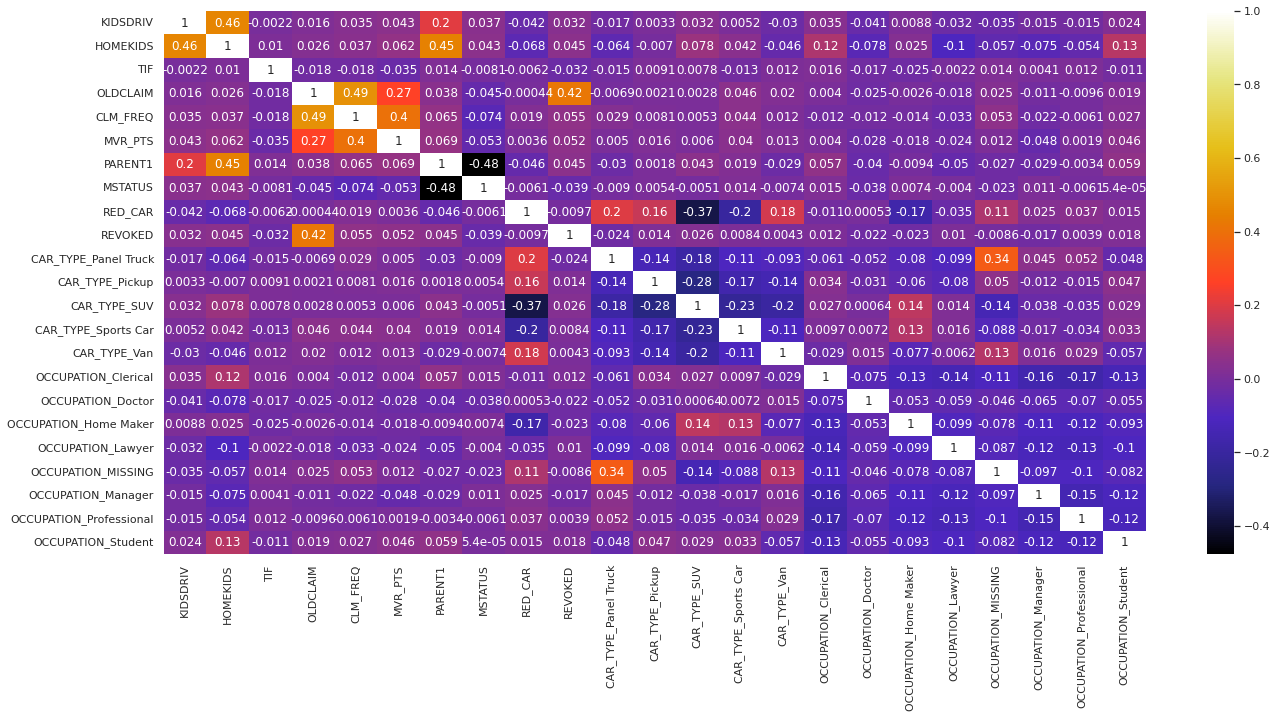

In [41]:
plot_corr(train_cv_df_imp_enc_vif.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold'], axis=1))

Generally, multicollinearity occurs when correlation is > 0.7 and since removing high VIF features, there are no strongly correlated features.

### 5.3 Using Correlation
To validate our approach with VIF, another common method is using Pearson correlation.


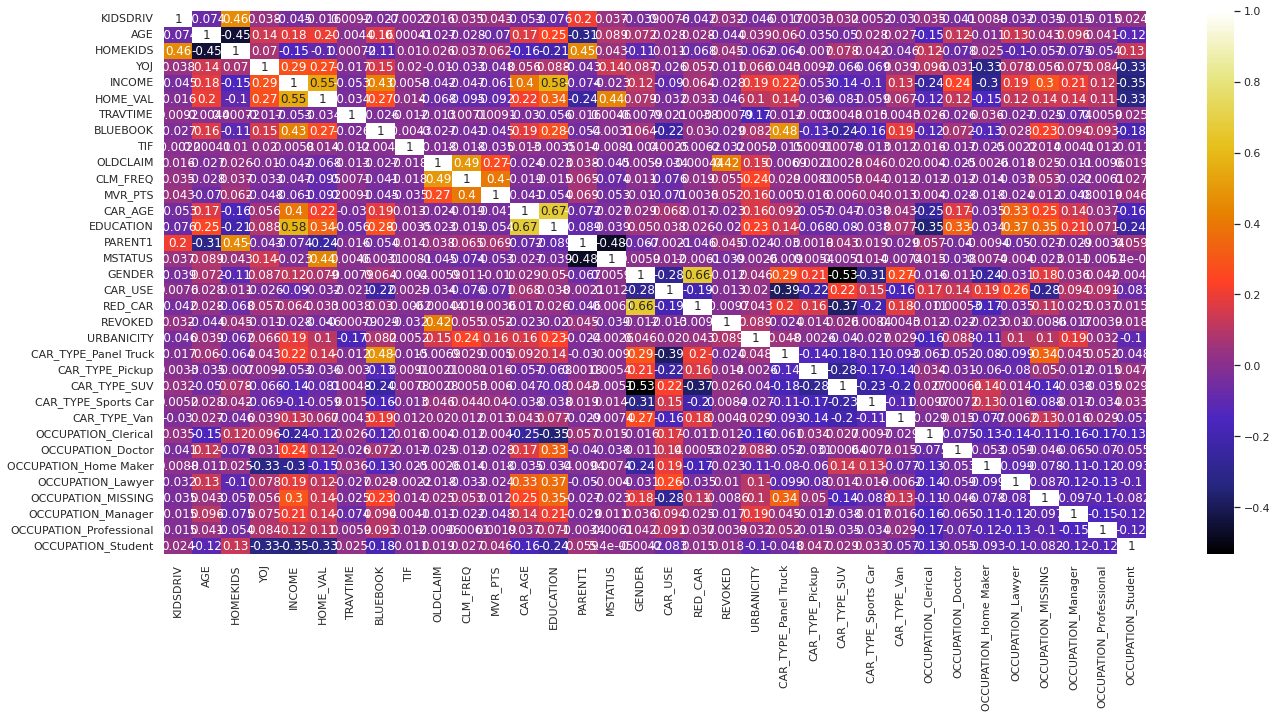

In [42]:
plot_corr(train_cv_df_imp_enc_.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold'], axis=1))

In [43]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
rfe = RFE(
estimator=model,
n_features_to_select=10
)

X = train_cv_df_imp_enc_.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold'], axis=1)

pipe = Pipeline([('rfe',rfe)])
X_transformed = pipe.fit_transform(X, train_cv_df_imp_enc_['TGT_CLAIM_FLAG'])
support = pipe.named_steps['rfe'].support_
X.columns[support]


# X = train_cv_df_imp_enc_.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT'], axis=1)
# y = train_cv_df_imp_enc_['TGT_CLAIM_FLAG']
# model = RandomForestRegressor()
# sfm = SelectFromModel(estimator=model)
# X_transformed = sfm.fit_transform(X, y)
# support = sfm.get_support()
# g = [x for x, y in zip(X.columns, support) if y == True]
# h = [c for c in X.columns if c not in g]
# print(h)

Index(['AGE', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'TIF',
       'OLDCLAIM', 'MVR_PTS', 'CAR_AGE'],
      dtype='object')

In [44]:
# from vif
['AGE' 'YOJ' 'INCOME' 'HOME_VAL' 'TRAVTIME' 'BLUEBOOK' 'CAR_AGE' 'EDUCATION' 'GENDER' 'CAR_USE' 'URBANICITY']

# from rfe
['AGE' 'YOJ' 'INCOME' 'HOME_VAL' 'TRAVTIME' 'BLUEBOOK' 'TIF' 'OLDCLAIM' 'MVR_PTS' 'CAR_AGE']


['AGEYOJINCOMEHOME_VALTRAVTIMEBLUEBOOKTIFOLDCLAIMMVR_PTSCAR_AGE']

Okay, now we have selected our features, and have everything we need to begin fitting the model.

# 6. Fitting the Model
To ensure our steps are all consistent and accurate, we'll use pipelines to manage all the imputing, encoding, selection and whatever transformations in between. The pipeline ensures that whatever we apply on the training set, we can also apply on the test set.

Below, I define a custom class that works with the `sklearn.pipeline` class.

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor

# The FeatureSelector class inherits from the sklearn.base classes 
# (BaseEstimator, TransformerMixin). This makes it compatible with 
# scikit-learn’s Pipelines
class FeatureSelectorVIF(BaseEstimator, TransformerMixin):
    def __init__(self,vif_threshold=5, inplace:bool=False):
        self.drop_cols = []
        self.vif_threshold = vif_threshold
        self.inplace = inplace
        
    def fit(self, X, y = None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)        
        X_cols = X.columns
        X_val = X.values
        vif_values = [
            variance_inflation_factor(X_val, i) for i in range(len(X_cols))
            ]
        vif_df = pd.DataFrame(zip(X_cols, vif_values),columns=['Variable','VIF'])
        self.drop_cols = vif_df.loc[vif_df['VIF']>self.vif_threshold]['Variable'].values
        return self

    def transform(self, X, y = None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)     
        return X.drop(self.drop_cols, axis=1, inplace=self.inplace)

    def fit_transform(self, X, y = None):
        return self.fit(X, y).transform(X, y)

With that out of the way, let's build the pipeline which the model should run through

In [46]:
# Redefine the imputers/encoders for the pipeline
knn_imputer = KNNImputer(n_neighbors=2)
cat_imputer = SimpleImputer(strategy='constant', fill_value='NONE')
ordinal_encoder_EDUCATION = OrdinalEncoder(categories=EDUCATION_ordinal)
binary_encoder = OrdinalEncoder()
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first') # added drop first to skip the step of removing one of the newly encoded features
fs_vif = FeatureSelectorVIF()

# Define transformers for numerical and categorical
numerical_transformer = knn_imputer

categorical_ord_transformer = Pipeline(steps=[
    ('cat_imputer', cat_imputer),
    ('ord', ordinal_encoder_EDUCATION),
])

categorical_bin_transformer = Pipeline(steps=[
    ('cat_imputer', cat_imputer),
    ('bin', binary_encoder),
])

categorical_ohe_transformer = Pipeline(steps=[
    ('cat_imputer', cat_imputer),
    ('nom', oh_encoder),
])

# Set out the above transformers into a ColumnTransformer class
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat_ord', categorical_ord_transformer, categorical_cols_ord),
        ('cat_bin', categorical_bin_transformer, categorical_cols_bin),
        ('cat_ohe', categorical_ohe_transformer, categorical_cols_nom)
    ])

# Define pipeline steps
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('fs', fs_vif),
])

In [47]:
# Define the model
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 0.1,
            'n_estimators':100
        }         
           
# Instantiate the classifier 
xgb_clf = XGBClassifier(**params)

In [48]:
processed_df_tmp = pd.DataFrame(xgb_pipeline.fit_transform(train_cv_df.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold'], axis=1)))

categorical_cols_nom_new = list(xgb_pipeline.named_steps['preprocessor'].transformers_[3][1].named_steps['nom'].get_feature_names_out(categorical_cols_nom))
new_cols = numerical_cols + categorical_cols_ord + categorical_cols_bin + categorical_cols_nom_new

for i in sorted(fs_vif.drop_cols,reverse=True):
    del new_cols[i]

processed_df_tmp.columns = new_cols

processed_df = pd.concat([processed_df_tmp,
    train_cv_df[['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold']]], axis=1)

# Validate the pipeline against the manual transforms:
print('The pipeline output is the same as the manual transform:',processed_df.equals(train_cv_df_imp_enc_vif))

The pipeline output is the same as the manual transform: False


In [49]:
def split_tgt(df, step):
    # step is either 0 or 1, 0 being the classification problem and 1 the regression problem
    tgt_cols = ['TGT_CLAIM_FLAG','TGT_CLAIM_AMT']
    tgt_col = tgt_cols[step]
    X = df.copy()
    y = X.pop(tgt_col)
    X.drop(tgt_cols[1-step], axis=1, inplace=True)
    return X, y

def split_folds(df, fold_, step):    
    train_df = df.loc[df['kfold'] != fold_].drop('kfold', axis=1)
    valid_df = df.loc[df['kfold'] == fold_].drop('kfold', axis=1)
    X_train, y_train = split_tgt(train_df, step)
    X_valid, y_valid = split_tgt(valid_df, step)
    return X_train, X_valid, y_train, y_valid

def run_fold(df, fold_, model, step):
    X_train, X_valid, y_train, y_valid = split_folds(df, fold_, step)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred = [1 if y > 0.5 else 0 for y in y_pred]
    display(pd.DataFrame(confusion_matrix(y_valid, y_pred),columns=['Pred_0','Pred_1'], index=['Actual_0','Actual_1']))
    accuracy = accuracy_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_pred)
    print('Accuracy score:',accuracy)
    print('AUC score:',auc)
    return accuracy, auc
    
def run_all_folds(df, model, step):
    avg_acc = []
    avg_auc = []
    for fold_ in range(n_folds):
        print('Fold:',fold_ + 1, 'of', n_folds)
        acc, auc = run_fold(df, fold_, model, 0)
        avg_acc.append(acc)
        avg_auc.append(auc)
        print('\n -----------------------------------')
    print('Average Accuracy Score is:', np.mean(avg_acc))
    print('Average AUC Score is:', np.mean(avg_auc))
run_all_folds(processed_df, xgb_clf, 0)


Fold: 1 of 5


,Pred_0,Pred_1
Actual_0,1245,65
Actual_1,348,145


Accuracy score: 0.7709373266777593
AUC score: 0.6222496632240683

 -----------------------------------
Fold: 2 of 5


,Pred_0,Pred_1
Actual_0,1212,100
Actual_1,315,176


Accuracy score: 0.7698280643372157
AUC score: 0.641116313148875

 -----------------------------------
Fold: 3 of 5


,Pred_0,Pred_1
Actual_0,1228,87
Actual_1,336,152


Accuracy score: 0.7653910149750416
AUC score: 0.6226578570092877

 -----------------------------------
Fold: 4 of 5


,Pred_0,Pred_1
Actual_0,1216,90
Actual_1,355,141


Accuracy score: 0.7530521642619312
AUC score: 0.6076807414908857

 -----------------------------------
Fold: 5 of 5


,Pred_0,Pred_1
Actual_0,1262,97
Actual_1,294,149


Accuracy score: 0.7830188679245284
AUC score: 0.6324835516753955

 -----------------------------------
Average Accuracy Score is: 0.7684454876352953
Average AUC Score is: 0.6252376253097024


In [50]:
# Define the model
params_2 = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 0.1,
            'n_estimators':100
            
        }

# Instantiate the classifier 
xgb_clf_2 = XGBClassifier(**params_2)

run_all_folds(processed_df, xgb_clf_2, 0)

Fold: 1 of 5


,Pred_0,Pred_1
Actual_0,1245,65
Actual_1,348,145


Accuracy score: 0.7709373266777593
AUC score: 0.6222496632240683

 -----------------------------------
Fold: 2 of 5


,Pred_0,Pred_1
Actual_0,1212,100
Actual_1,315,176


Accuracy score: 0.7698280643372157
AUC score: 0.641116313148875

 -----------------------------------
Fold: 3 of 5


,Pred_0,Pred_1
Actual_0,1228,87
Actual_1,336,152


Accuracy score: 0.7653910149750416
AUC score: 0.6226578570092877

 -----------------------------------
Fold: 4 of 5


,Pred_0,Pred_1
Actual_0,1216,90
Actual_1,355,141


Accuracy score: 0.7530521642619312
AUC score: 0.6076807414908857

 -----------------------------------
Fold: 5 of 5


,Pred_0,Pred_1
Actual_0,1262,97
Actual_1,294,149


Accuracy score: 0.7830188679245284
AUC score: 0.6324835516753955

 -----------------------------------
Average Accuracy Score is: 0.7684454876352953
Average AUC Score is: 0.6252376253097024


# 7. Hyperparameter Optimisation

In [51]:
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processed_df.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT'],axis=1), processed_df['TGT_CLAIM_FLAG'], test_size=0.33, random_state=1)
mse, bias, var = bias_variance_decomp(xgb_clf, X_train.values, y_train.values, X_test.values, y_test.values, loss='mse', num_rounds=200, random_seed=1)
# summarize results
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.237
Bias: 0.203
Variance: 0.033


In [52]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.choice("max_depth", np.arange(3, 18, dtype=int)),
        'gamma': hp.uniform ('gamma', 0.05,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 50, 1),
        'n_estimators': 180,
        'seed': 0
    }

# Instantiate the classifier 

def objective(space):
    params_1 = {
        'objective' : 'binary:logistic',
        'eval_metric':'error',
        'n_estimators' : space['n_estimators'],
        'max_depth' : int(space['max_depth']),
        'gamma' : space['gamma'],
        'reg_alpha' : int(space['reg_alpha']),
        'min_child_weight' : int(space['min_child_weight']),
        'colsample_bytree' : int(space['colsample_bytree']),
        'early_stopping_rounds' : 10
    }
    xgb_clf_1 = XGBClassifier(**params_1)
    
    X_train, X_valid, y_train, y_valid = split_folds(processed_df, 0, 0)

    evaluation = [(X_train, y_train), (X_valid, y_valid)]
    
    xgb_clf_1.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=False)

    y_pred = xgb_clf_1.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

# run_all_folds(processed_df, xgb_clf_1, 0)


SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.7265668330560178
SCORE:
0.726

In [53]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7163694589563239, 'gamma': 2.512162594308338, 'max_depth': 1, 'min_child_weight': 46.0, 'reg_alpha': 118.0, 'reg_lambda': 0.2426481002763523}


In [54]:
# Instantiate the classifier 
xgb_clf_2 = XGBClassifier(**best_hyperparams)

run_all_folds(processed_df,xgb_clf_2,0)

Fold: 1 of 5


,Pred_0,Pred_1
Actual_0,1310,0
Actual_1,493,0


Accuracy score: 0.7265668330560178
AUC score: 0.5

 -----------------------------------
Fold: 2 of 5


,Pred_0,Pred_1
Actual_0,1312,0
Actual_1,491,0


Accuracy score: 0.7276760953965613
AUC score: 0.5

 -----------------------------------
Fold: 3 of 5


,Pred_0,Pred_1
Actual_0,1315,0
Actual_1,488,0


Accuracy score: 0.7293399889073766
AUC score: 0.5

 -----------------------------------
Fold: 4 of 5


,Pred_0,Pred_1
Actual_0,1306,0
Actual_1,496,0


Accuracy score: 0.7247502774694784
AUC score: 0.5

 -----------------------------------
Fold: 5 of 5


,Pred_0,Pred_1
Actual_0,1359,0
Actual_1,443,0


Accuracy score: 0.7541620421753608
AUC score: 0.5

 -----------------------------------
Average Accuracy Score is: 0.7324990474009588
Average AUC Score is: 0.5
